In [8]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print('Running on CoLab')
else:
    colab = False
    # enable full width for wide figures
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
    print('Not running on CoLab')

if colab:
  %matplotlib inline
else:
  %matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
if colab == True: mpl.rc('animation', html='jshtml')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from scipy.stats import norm # cumulative normal distribution

# enable full width for wide figures
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

# constants
epsilon = 1.0e-08

Not running on CoLab


In [35]:
class DiffPCA:
    
    def __init__(self, n_components=None, central=False):
        """
        The API is consistent with sklearn.decomposition.PCA 
        (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
        
        n_components = number of components to keep. If n_components is None all components are kept:
        n_components == n_features
        
        If 0 < n_components < 1, select the number of components such that 
        the amount of 'variance' (squared magnitude) that needs to be explained is greater than the percentage specified by n_components
        
        Default = squared error magnitude (epsilon*total_variance in the article) of 10^(-8), i.e. error norm is 0.01% of total norm
                        
        central = specific to differential PCA, standard scikit-learn PCA is always central. By contrast, 
        differential PCA is noncentral by default, see article
        """
        
        self.n_components = n_components
        self.central = central
        
    def fit(self, X, Z, y=None): # note y is ignored, just like in scikit-learn PCA
        """
        X: input data
        Z: differential data = dy/dZ, see article
        (y: labels)
        """
        
        # copy data
        self.X = X.copy() 
        self.y = y.copy() if y else None
        self.Z = Z.copy() 
        self.n_samples_, self.n_features_ = self.X.shape
        
        # central?
        self.mean_ = self.Z.mean(axis=0) # average differentials
        if self.central: self.Z -= self.mean_ # demean differentials
            
        # compute covariance matrix of differentials
        self.cov_ = self.Z.T @ self.Z / self.n_samples_
        
        # eigenvalue decomposition
        d, P = np.linalg.eigh(self.cov_)
                
        # reverse order so largest eigenvalues come first
        d = d[::-1]
        P = P[:, ::-1]
        
        sumd = np.cumsum(d)
        total_variance = sumd[-1]

        # find the number of principal components
        if self.n_components is not None: 
            # n_components is larger than 1 = number of components
            if self.n_components >= 1:
                self.n_components_ = self.n_components
            # n_components is smaller than 1 = square magnitude explained
            else:
                sumd /= total_variance
                self.n_components_ = np.searchsorted(sumd, self.n_components) + 1    
        
        else:
            self.n_components_ = min(self.n_samples_, self.n_features_)
            
        explained = sumd[self.n_components_-1]
        unexplained = total_variance - explained

        # filter
        d = d[:self.n_components_]
        P = P[:, :self.n_components_]
            
        # results, attributes as in sklearn.decomposition.PCA
        self.components_ = P.T
        self.explained_variance_ = d
        self.explained_variance_ratio_ = d / total_variance
        self.singular_values_ = np.sqrt(d)
        self.noise_variance_ = unexplained
        
    def transform(self, X, Z=None): 
        
        # transformed dataset
        L = X @ self.components_.T
        
        if Z is None:
            return L
        
        else:
            # transformed derivatives
            S = Z @ self.components_.T
            return L, S
        
    def fit_transform(self, X, Z, y=None):
        self.fit(X, Z, y)
        return self.transform(X, Z)
    
    def inverse_transform(self, L, S=None):
        
        # L to X
        X = L @ self.components_
        
        if S is None:
            return X
        
        else:
            # S to Z
            Z = S @ self.components_
            return X, Z

In [36]:
# classic and differential variants of polynomial regression

def make_polynomial(degree=5):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(normalize=True))

class DifferentialRegression:
    
    def __init__(self, degree=5, alpha=1.0):
        self.degree = degree
        self.polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)
        self.alpha = alpha
    
    def fit(self, x, y, z):     
        self.phi_ = self.polynomial_features.fit_transform(x)
        self.powers_ = self.polynomial_features.powers_
        
        self.dphi_ = self.phi_[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + epsilon)
                
        self.lamj_ = ((y ** 2).mean(axis=0) / (z ** 2).mean(axis=0)).reshape(1,1,-1)
        self.dphiw_ = self.dphi_ * self.lamj_
        
        phiTphi = np.tensordot(self.dphiw_, self.dphi_, axes=([0,2],[0,2]))
        phiTz = np.tensordot(self.dphiw_, z, axes=([0,2],[0,1])).reshape(-1,1)
        
        # note we use np.linalg.pinv (as opposed to np.linalg.inv) to perform safe (SVD) inversion, resilient to near singularities
        inv = np.linalg.pinv(self.phi_.T @ self.phi_ + self.alpha * phiTphi, hermitian=True)
        self.beta_ = (inv @ (self.phi_.T @ y + self.alpha * phiTz)).reshape(-1, 1)
        
    def predict(self, x, predict_derivs=False):
        phi = self.polynomial_features.transform(x)
        y_pred = phi @ self.beta_
        
        if predict_derivs:
            dphi = phi[:, :, np.newaxis] * self.powers_[np.newaxis, :, :] / (x[:, np.newaxis, :] + eps)
            z_pred = np.tensordot(dphi, self.beta_, (1, 0)).reshape(dphi.shape[0], -1)
            return y_pred, z_pred
        else:
            return y_pred

In [37]:
# read dataset

x_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_x_train.csv", header=None).to_numpy() 
y_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_y_train.csv", header=None).to_numpy() 
z_train = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_z_train.csv", header=None).to_numpy() 
x_test = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_x_test.csv", header=None).to_numpy() 
y_test = pd.read_csv("https://raw.githubusercontent.com/differential-machine-learning/notebooks/master/data/berm_5f_y_test.csv", header=None).to_numpy() 



In [38]:
x_train.shape, y_train.shape, z_train.shape, x_test.shape, y_test.shape

((32768, 5), (32768, 1), (32768, 5), (128, 5), (128, 1))

In [39]:
x_train.mean(axis=0)

array([-5.63975140e-06,  2.99983821e-05, -2.95852671e-05,  1.19429573e-05,
        1.61102240e-06])

In [40]:
x_train.std(axis=0)

array([0.00968803, 0.07526288, 0.19165607, 0.18689005, 0.06663135])

In [41]:
np.corrcoef(x_train.T)

array([[ 1.        , -0.43407826,  0.29209756, -0.26197849,  0.23159355],
       [-0.43407826,  1.        , -0.94521438,  0.83892332, -0.70046631],
       [ 0.29209756, -0.94521438,  1.        , -0.96362085,  0.86095065],
       [-0.26197849,  0.83892332, -0.96362085,  1.        , -0.95947824],
       [ 0.23159355, -0.70046631,  0.86095065, -0.95947824,  1.        ]])

<IPython.core.display.Javascript object>


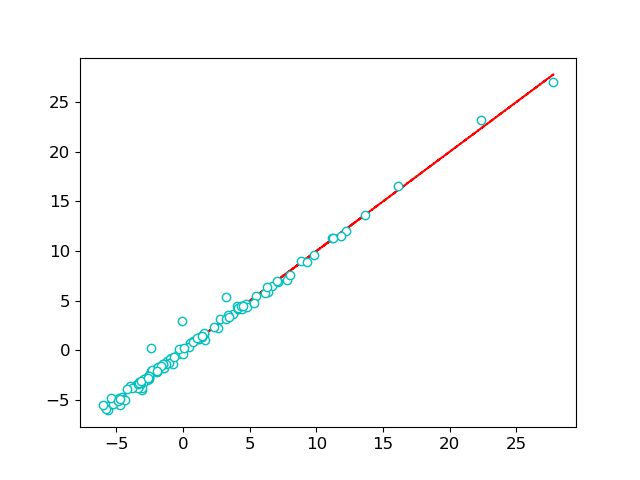

In [42]:
classic_reg = make_polynomial()
classic_reg.fit(x_train, y_train)
pred = classic_reg.predict(x_test)

plt.figure()
plt.plot(y_test, y_test, 'r--')
plt.plot(y_test, pred, 'co', markerfacecolor="white")


<IPython.core.display.Javascript object>


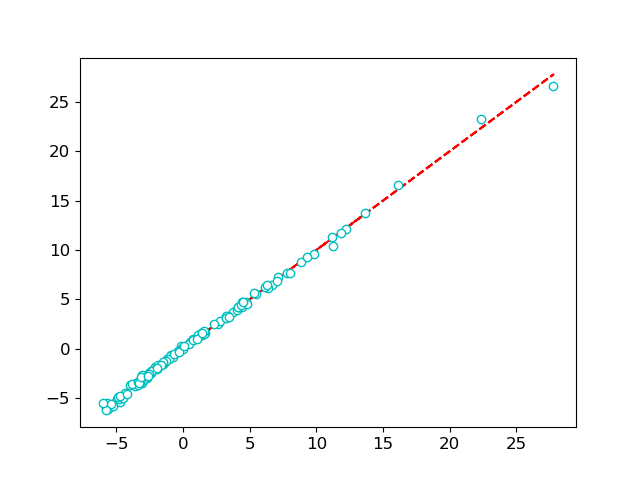

In [43]:
diff_reg = DifferentialRegression()
diff_reg.fit(x_train, y_train, z_train)
pred = diff_reg.predict(x_test)

plt.figure()
plt.plot(y_test, y_test, 'r--')
plt.plot(y_test, pred, 'co', markerfacecolor="white")


<IPython.core.display.Javascript object>


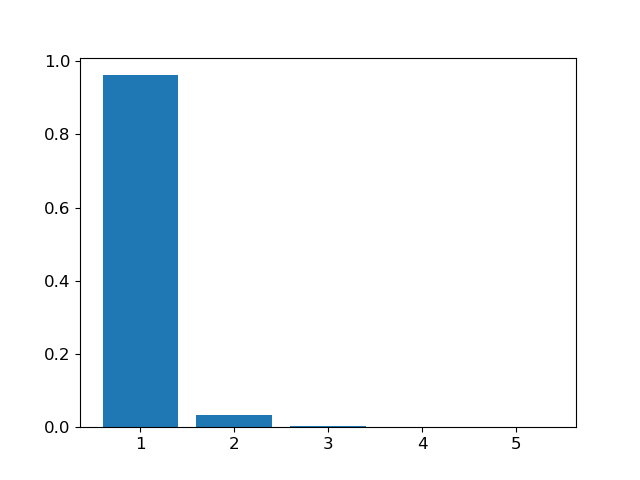

<BarContainer object of 5 artists>

In [44]:
pca = PCA()
pca.fit(x_train)

plt.figure()
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)

In [60]:
pca = PCA(4)
x_reduced = pca.fit_transform(x_train)
z_reduced = pca.transform(z_train)
print(x_reduced.shape, z_reduced.shape)

(32768, 4) (32768, 4)


<IPython.core.display.Javascript object>


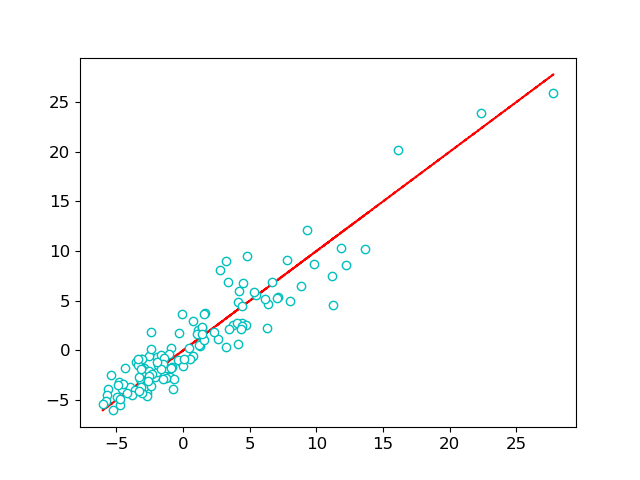

In [61]:
classic_reg.fit(x_reduced, y_train)
pred = classic_reg.predict(pca.transform(x_test))

plt.figure()
plt.plot(y_test, y_test, 'r--')
plt.plot(y_test, pred, 'co', markerfacecolor="white")


<IPython.core.display.Javascript object>


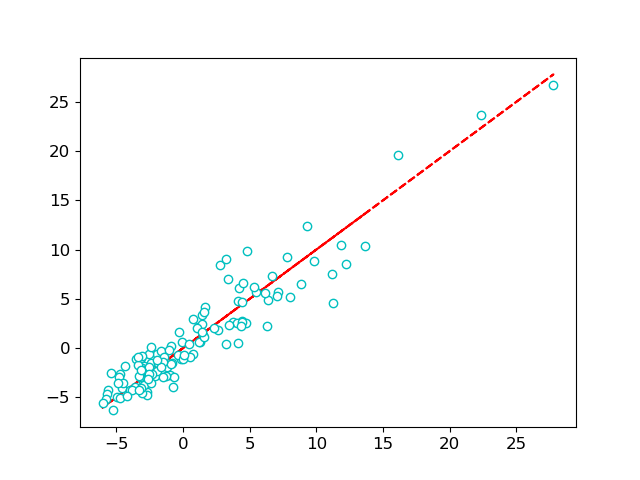

In [62]:
diff_reg = DifferentialRegression()
diff_reg.fit(x_reduced, y_train, z_reduced)
pred = diff_reg.predict(pca.transform(x_test))

plt.figure()
plt.plot(y_test, y_test, 'r--')
plt.plot(y_test, pred, 'co', markerfacecolor="white")


<IPython.core.display.Javascript object>


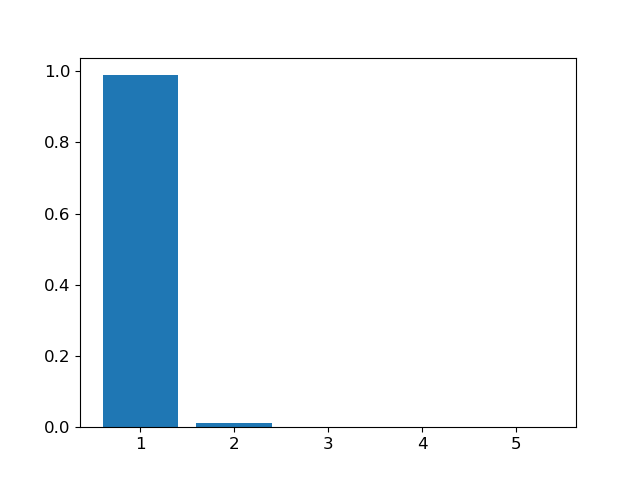

<BarContainer object of 5 artists>

In [48]:
dpca = DiffPCA()
dpca.fit(x_train, z_train)

plt.figure()
plt.bar(range(1, dpca.n_components_ + 1), dpca.explained_variance_ratio_)

In [54]:
dpca = DiffPCA(1)
x_reduced, z_reduced = dpca.fit_transform(x_train, z_train)
print(x_reduced.shape, z_reduced.shape)

(32768, 1) (32768, 1)


<IPython.core.display.Javascript object>


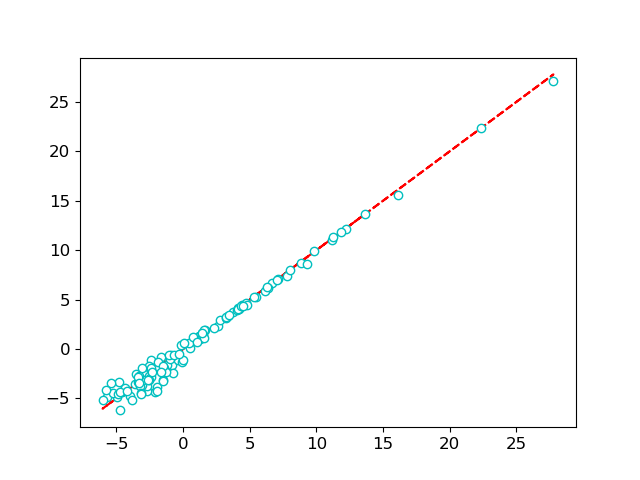

In [55]:
classic_reg.fit(x_reduced, y_train)
pred = classic_reg.predict(dpca.transform(x_test))

plt.figure()
plt.plot(y_test, y_test, 'r--')
plt.plot(y_test, pred, 'co', markerfacecolor="white")


<IPython.core.display.Javascript object>


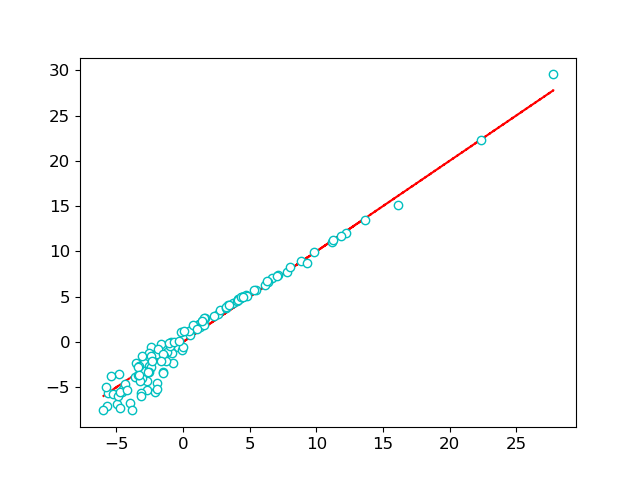

In [56]:
diff_reg = DifferentialRegression()
diff_reg.fit(x_reduced, y_train, z_reduced)
pred = diff_reg.predict(dpca.transform(x_test))

plt.figure()
plt.plot(y_test, y_test, 'r--')
plt.plot(y_test, pred, 'co', markerfacecolor="white")

In [83]:
pca = PCA(4)
x_scaled = (x_train-x_train.mean(axis=0)) / x_train.std(axis=0)
z_scaled = z_train * x_train.std(axis=0)
x_reduced = pca.fit_transform(x_scaled)
z_reduced = pca.transform(z_scaled)
print(x_reduced.shape, z_reduced.shape)

(32768, 4) (32768, 4)


<IPython.core.display.Javascript object>


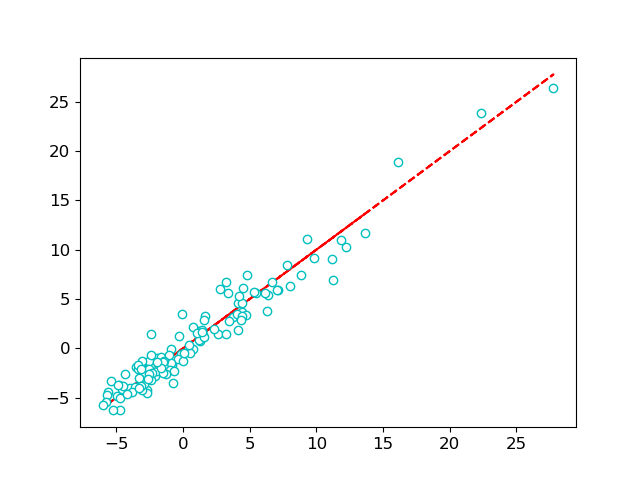

In [84]:
classic_reg.fit(x_reduced, y_train)
pred = classic_reg.predict(pca.transform((x_test - x_train.mean(axis=0)) / x_train.std(axis=0)))

plt.figure()
plt.plot(y_test, y_test, 'r--')
plt.plot(y_test, pred, 'co', markerfacecolor="white")

In [85]:
ks = np.array([0.0, 0.1, 0.25, 0.5, 1.0]).reshape(1, -1)

def forward_curve(X, ks=ks):
    
    def f(T):
        return np.dot(np.exp(-ks * T), X)
    
    return f
        

In [86]:
X = x_train[47]

In [87]:
f = forward_curve(X)

<IPython.core.display.Javascript object>


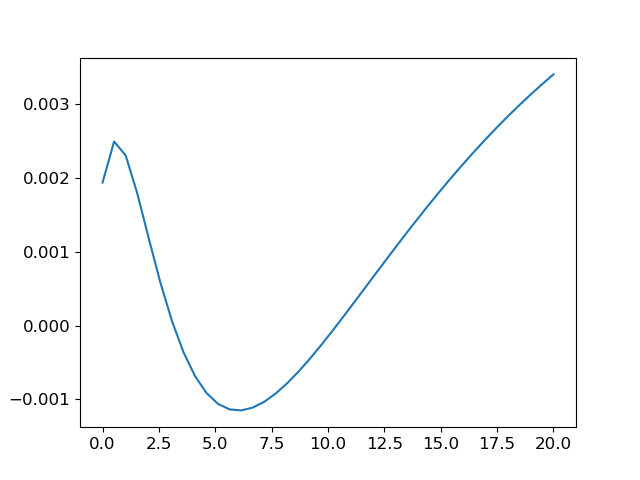

In [88]:
ts = np.linspace(0, 20, 40).reshape(-1, 1)

plt.figure()
plt.plot(ts, f(ts))

In [89]:
ks.shape

(1, 5)

In [90]:
ts.shape

(40, 1)

In [91]:
(ks*ts).shape

(40, 5)

In [104]:
pca = PCA()
pca.fit(x_train)
scaled_components = pca.components_ * np.sqrt(pca.explained_variance_).reshape(-1, 1)

In [105]:
scaled_components

array([[ 0.00281742, -0.06828391,  0.19012787, -0.1848907 ,  0.06110423],
       [-0.00209711,  0.03004345, -0.02350643, -0.02710525,  0.02479553],
       [ 0.0066399 , -0.00990877, -0.00546028,  0.00092124,  0.00839816],
       [-0.00603343, -0.00062205,  0.00119739,  0.00285679,  0.00450146],
       [ 0.00101714,  0.0008961 ,  0.0008742 ,  0.00082509,  0.00073097]])

<IPython.core.display.Javascript object>


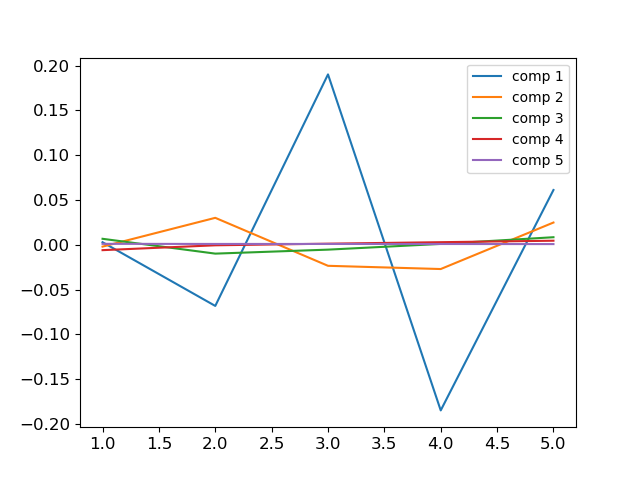

In [109]:
plt.figure()
for i, component in enumerate(scaled_components):
    plt.plot(range(1, 6), component, label='comp %d' % (i+1))
plt.legend()

<IPython.core.display.Javascript object>


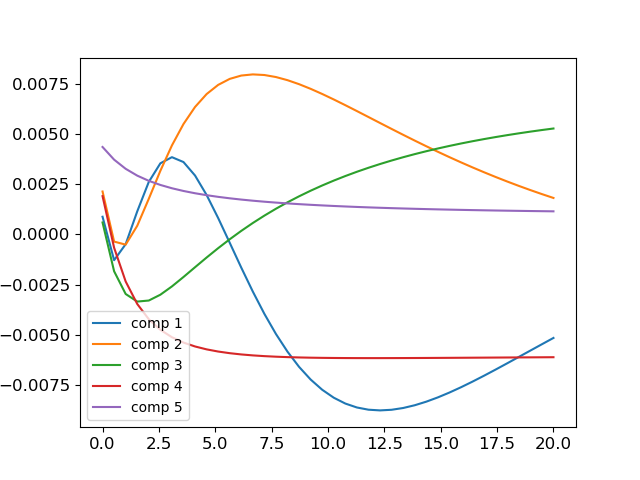

In [110]:
plt.figure()
for i, component in enumerate(scaled_components):
    f = forward_curve(component)
    plt.plot(ts, f(ts), label='comp %d' % (i+1))
plt.legend()